# Using MIGHTI data from NASA Ionospheric Connections Explorer

In [1]:
# Import packages
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore", message="'S' is deprecated and will be removed in a future version, please use 's' instead.")

In [2]:
import pysat

In [3]:
# Set data directory if user hasn't already set one
print(f"old: {pysat.params['data_dirs']}")
if len(pysat.params['data_dirs']) == 0 or pysat.params['data_dirs'] == ['.']:
    # Set a directory for pysat to use for data
    pysat.params['data_dirs'] = '/home/jovyan/scratch_space/.pysat/'
else:
    print('pysat directory has been set previously. Leaving unchanged.')

print(f"new: {pysat.params['data_dirs']}")

old: ['/home/jovyan/scratch_space/.pysat']
pysat directory has been set previously. Leaving unchanged.
new: ['/home/jovyan/scratch_space/.pysat']


In [4]:
# Register instruments with pysat. Only needed once per install.
import pysatNASA
pysat.utils.registry.register(['pysatNASA.instruments.icon_mighti'])

# Improvements for loading ICON metadata are currently in
# https://github.com/pysat/pysatNASA/pull/100.
warnings.simplefilter('ignore', UserWarning)

In [5]:
# First, obtain MIGHTI data from NASA CDAWeb.

# Instantiate pysat.Instrument objects for the MIGHTI data products
# MIGHTI Vector wind red.
mighti_vw_red = pysat.Instrument('icon', 'mighti', tag='vector_wind_red',
                                 inst_id='vector')

# MIGHTI Vector wind green.
mighti_vw_green = pysat.Instrument('icon', 'mighti', tag='vector_wind_green',
                                   inst_id='vector')

# MIGHTI Temperature.
mighti_temp_a = pysat.Instrument('icon', 'mighti', tag='temperature',
                                 inst_id='a')
mighti_temp_b = pysat.Instrument('icon', 'mighti', tag='temperature',
                                 inst_id='b')

# Collect into a list.
mighti_insts = [mighti_vw_red, mighti_vw_green, mighti_temp_a, mighti_temp_b]

In [6]:
# Learn more about MIGHT
help(mighti_insts[0].inst_module)

Help on module pysatNASA.instruments.icon_mighti in pysatNASA.instruments:

NAME
    pysatNASA.instruments.icon_mighti - Module for the ICON MIGHTI instrument.

DESCRIPTION
    Supports the Michelson Interferometer for Global High-resolution
    Thermospheric Imaging (MIGHTI) instrument onboard the Ionospheric
    CONnection Explorer (ICON) satellite.  Accesses local data in
    netCDF format.
    
    Properties
    ----------
    platform
        'icon'
    name
        'mighti'
    tag
        Supports 'los_wind_green', 'los_wind_red', 'vector_wind_green',
        'vector_wind_red', 'temperature'.  Note that not every data product
        available for every inst_id
    inst_id
        'vector', 'a', or 'b'
    
    Warnings
    --------
    - The cleaning parameters for the instrument are still under development.
    - Only supports level-2 data.
    
    Example
    -------
    ::
    
        import pysat
        mighti = pysat.Instrument('icon', 'mighti', tag='vector_wind_green'

In [7]:
# Set range of dates for downloading ICON data
start_download_date = dt.datetime(2020, 1, 1)
stop_download_date = dt.datetime(2020, 1, 4)

In [8]:
# Download various MIGHTI data products

# If needed, change levels for logging printout to increase feedback.
# More information about logging may be found here:
# https://docs.python.org/3/library/logging.html
# pysat.logger.setLevel("INFO")

# Perform download for each dataset. Data is already downloaded for the workshop
# for inst in mighti_insts:
#     inst.download(start_download_date, stop_download_date)
    
# Change levels for logging printout to decrease feedback
# pysat.logger.setLevel("WARNING")

# MIGHTI Winds Basic Example

Text(0, 0.5, 'Altitude ()')

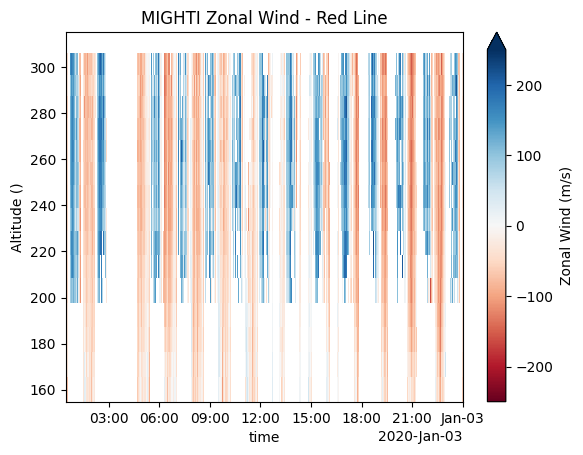

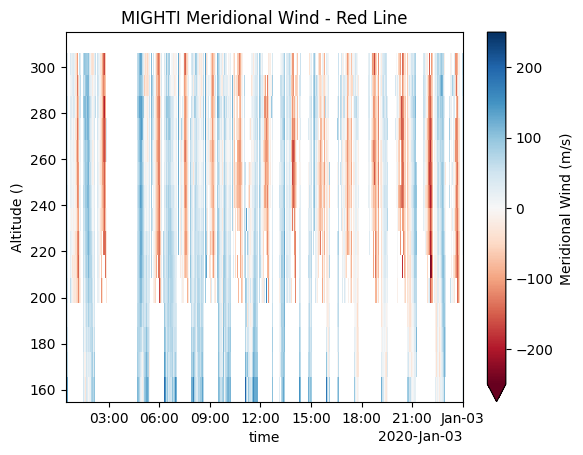

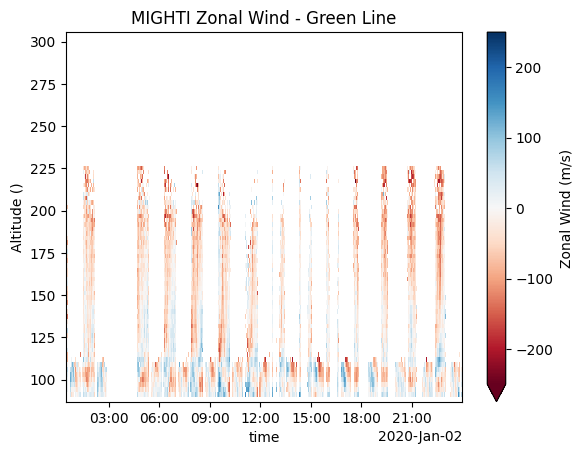

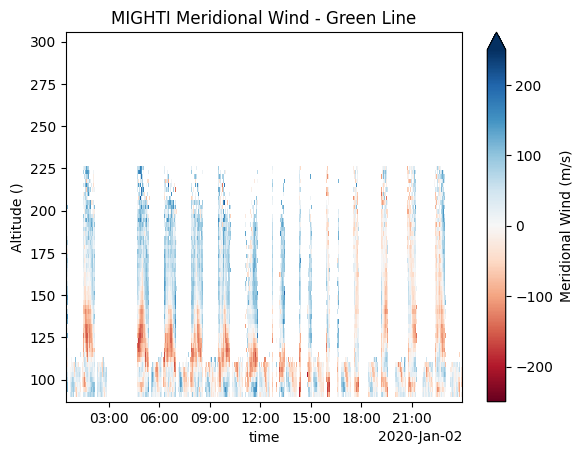

In [9]:
# Produce simple overview plot of MIGHTI winds for a day of data.

vmin = -250.
vmax = 250.
cmap = plt.cm.RdBu

# pysat features a variety of internal data checks to ensure data is
# consistent with expectations. Warnings are raised below relating to the
# treatment of ICON's metadata. An upcoming release to pysat improves the
# generality of metadata handling when loading files, which an upcoming
# release to pysatNASA utilizes. pysat > v3.0.1 and pysatNASA > 0.0.2

# Load day of data
mighti_vw_red.load(2020, 2)
mighti_vw_green.load(2020, 2)

# Zonal wind plot, red line
mighti_vw_red['Zonal_Wind'].transpose().plot(
    cbar_kwargs={'label': 'Zonal Wind (m/s)'}, vmin=vmin, vmax=vmax, cmap=cmap)
plt.title('MIGHTI Zonal Wind - Red Line')

# Use pysat's stored metadata to get units
ylabel = ''.join(['Altitude (', mighti_vw_red.meta['Altitude', 'units'], ')'])
plt.ylabel(ylabel)

# Meridional wind plot, red line
plt.figure()
mighti_vw_red['Meridional_Wind'].transpose().plot(
    cbar_kwargs={'label': 'Meridional Wind (m/s)'}, vmin=vmin, vmax=vmax,
    cmap=cmap)
plt.title('MIGHTI Meridional Wind - Red Line')
plt.ylabel(ylabel)

# Zonal wind plot, green line
plt.figure()
mighti_vw_green['Zonal_Wind'].transpose().plot(
    cbar_kwargs={'label': 'Zonal Wind (m/s)'}, vmin=vmin, vmax=vmax, cmap=cmap)
plt.title('MIGHTI Zonal Wind - Green Line')
plt.ylabel(ylabel)

# Meridional wind plot, green line
plt.figure()
mighti_vw_green['Meridional_Wind'].transpose().plot(
    cbar_kwargs={'label': 'Meridional Wind (m/s)'}, vmin=vmin, vmax=vmax,
    cmap=cmap)
plt.title('MIGHTI Meridional Wind - Green Line')
plt.ylabel(ylabel)

## MIGHTI Winds Summary Per-Orbit Example

Text(0.5, 0, 'Profile Average Solar Local Time')

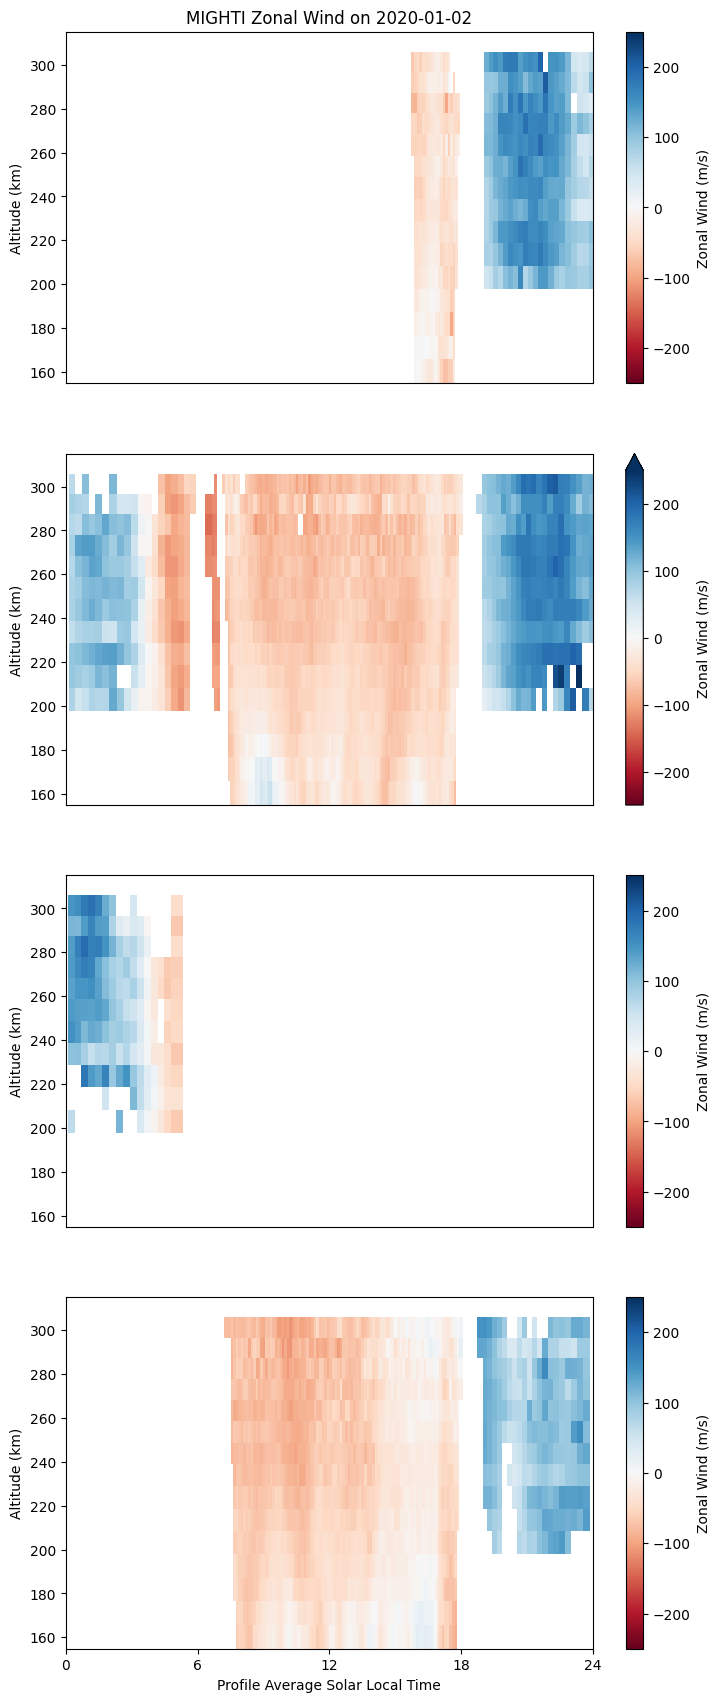

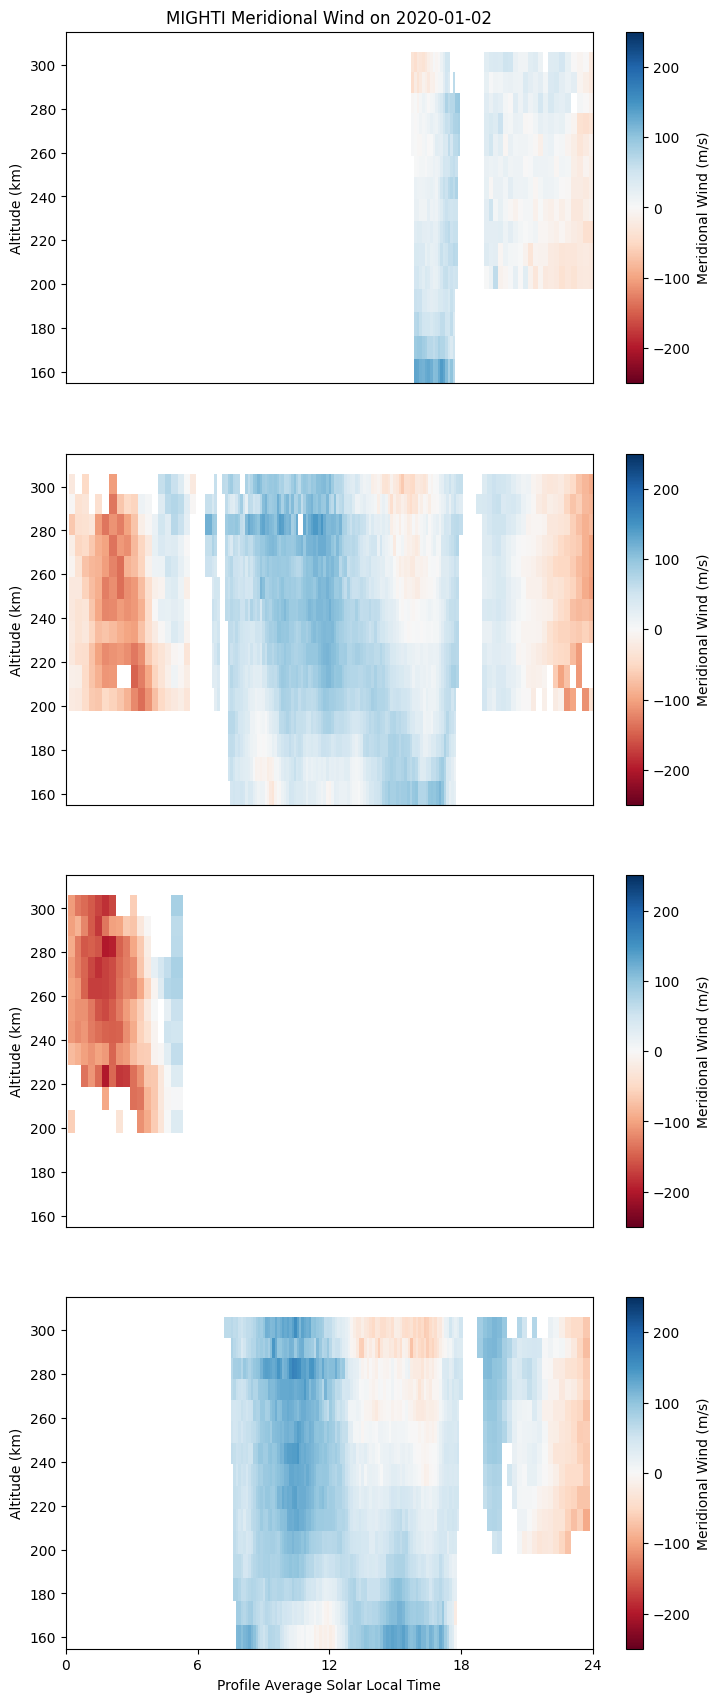

In [10]:
# Pick 'red' or 'green' for the line color MIGHTI is using
line_color = 'red'

# Set date
date = dt.datetime(2020, 1, 2)

# Set up orbit calculation parameters. Note that the 'average_local_time'
# variable is not available in the MIGHTI files, it will be added by pysat.
orbit_info = {'kind': 'lt', 'index': 'average_local_time'}

# The local time of the profiles varies as a function of height,
# make an average local time for use in calculations.
def add_average_local_solar_time(inst):
    """Adds mean profile local solar time as variable """

    # Average local time over profile.
    inst['average_local_time'] = inst['Local_Solar_Time'].mean(axis=1)

    # Remove overall times when there is no local time info.
    idx, = np.where(~inst['average_local_time'].isnull())
    inst.data = inst[idx]

    return
    
# MIGHTI Vector Wind
mighti_vw_color = pysat.Instrument('icon', 'mighti',
                                   tag='vector_wind_' + line_color,
                                   inst_id='vector',
                                   orbit_info=orbit_info)

# Confine orbit calculation to user set date
mighti_vw_color.bounds = (date, date)

# Add calculation of profile average local time
mighti_vw_color.custom_attach(add_average_local_solar_time)

# Create a figure so each orbit is on the same plot
# Zonal wind
fig, axs = plt.subplots(4, 1, figsize=(8.5,21))
# Meridional wind
figm, axsm = plt.subplots(4, 1, figsize=(8.5,21))

# Iterate over orbits and produce plots.
for i, lmighti_vw in enumerate(mighti_vw_color.orbits):
    # Enable support for plotting local_time on x-axis.
    alt = ("time", lmighti_vw['average_local_time'].data)

    # Zonal wind.
    a = lmighti_vw['Zonal_Wind'].assign_coords(average_local_time=alt)

    # Make plot.
    a.transpose().plot(ax=axs[i], x='average_local_time', y='Altitude',
                       cbar_kwargs={'label': 'Zonal Wind (m/s)'},
                       vmin=vmin, vmax=vmax, cmap=cmap)
    axs[i].set_xlim((0, 24))
    axs[i].set_xticks([])
    axs[i].set_xlabel('')
    axs[i].set_ylabel('Altitude (km)')

    # Meridional wind.
    a = lmighti_vw['Meridional_Wind'].assign_coords(average_local_time=alt)

    # Make plot.
    a.transpose().plot(ax=axsm[i], x='average_local_time', y='Altitude',
                       cbar_kwargs={'label': 'Meridional Wind (m/s)'},
                       vmin=vmin, vmax=vmax, cmap=cmap)
    axsm[i].set_xlim((0, 24))
    axsm[i].set_xticks([])
    axsm[i].set_xlabel('')
    axsm[i].set_ylabel('Altitude (km)')

    # For simplicity, terminate early.
    if i == 3:
        break


axs[0].set_title('MIGHTI Zonal Wind on ' + date.strftime('%Y-%m-%d'))
axs[-1].set_xticks([0, 6, 12, 18, 24])
axs[-1].set_xlabel('Profile Average Solar Local Time')

axsm[0].set_title('MIGHTI Meridional Wind on ' + date.strftime('%Y-%m-%d'))
axsm[-1].set_xticks([0, 6, 12, 18, 24])
axsm[-1].set_xlabel('Profile Average Solar Local Time')

## MIGHTI Temperature Example

Text(0.5, 0, 'Profile Average Solar Local Time')

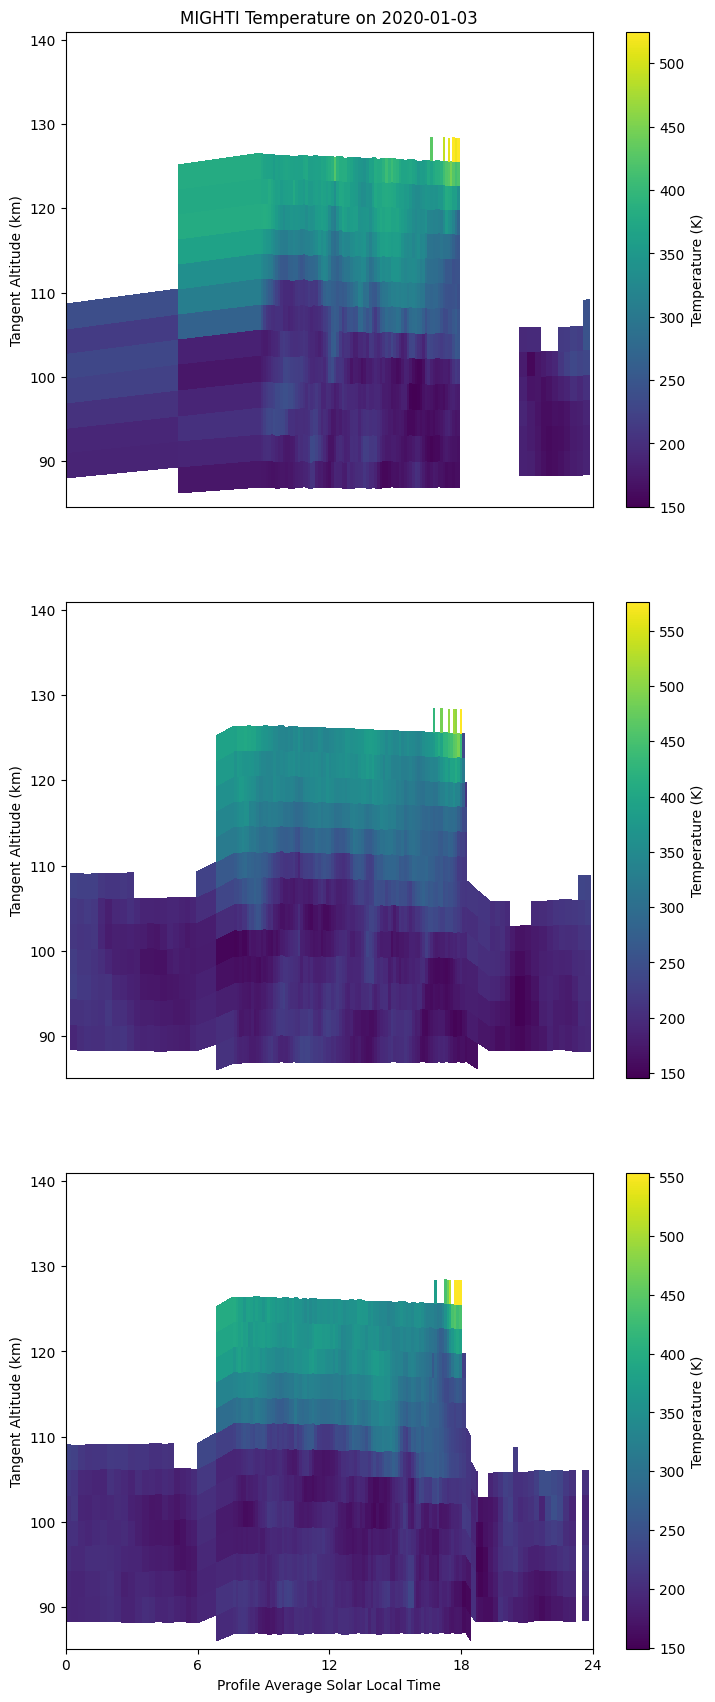

In [11]:
# Pick 'a' or 'b' for the MIGHTI instrument
inst_id = 'a'

# Set date
date = dt.datetime(2020, 1, 3)
date2 = dt.datetime(2020, 1, 4)

# Set parameters for orbit calculations.
# Note that 'average_local_time' is a custom variable.
orbit_info = {'kind': 'lt', 'index': 'average_local_time'}
    
# MIGHTI Temperature Instrument
mighti = pysat.Instrument('icon', 'mighti', tag='temperature',
                          inst_id=inst_id, orbit_info=orbit_info)

# Confine orbit calculation to user set date
mighti.bounds = (date, date2)

# Produce a simpler local time signal to work with
def add_average_tangent_solar_time(inst):
    """Adds mean profile local solar time as variable """
    # Average local time over profile
    inst['average_local_time'] = inst['Tangent_Local_Solar_Time'].mean(dim='Alt')
    idx, = np.where(~inst['average_local_time'].isnull())
    inst.data = inst[idx]
    return

# Add custom method - applied whenever mighti data is loaded.
mighti.custom_attach(add_average_tangent_solar_time)

# Create figure
first_loop = True
for i, lmighti in enumerate(mighti.orbits):
    if first_loop:
        # Create figure on first loop. We now know how many orbits in the day.
        # fig, axs = plt.subplots(mighti.orbits.num, 1, figsize=(8.5,21))

        # For simplicity, limited to only three orbits.
        fig, axs = plt.subplots(3, 1, figsize=(8.5,21))
        first_loop = False
    
    # Enable support for plotting local_time on x-axis
    slt = ("time", lmighti['average_local_time'].data)

    # Enable support for plotting tangent altitude on y axis
    alt = (("time", "Alt"), lmighti['Tangent_Altitude'].data)

    # Apply coordinates
    a = lmighti['Temperature'].assign_coords(average_local_time=slt,
                                             Tangent_Altitude=alt)

    # Ensure local time is monotonically increasing
    a = a.sortby(lmighti['average_local_time'])

    # Make plot
    a.transpose().plot(ax=axs[i], x='average_local_time', y='Tangent_Altitude',
                       cbar_kwargs={'label': 'Temperature (K)'})
    axs[i].set_xlim((0, 24))
    axs[i].set_xticks([])
    axs[i].set_xlabel('')
    axs[i].set_ylabel('Tangent Altitude (km)')

    if i == 2:
        break

# Set title and outermost x axis label
axs[0].set_title('MIGHTI Temperature on ' + date.strftime('%Y-%m-%d'))
axs[-1].set_xticks([0, 6, 12, 18, 24])
axs[-1].set_xlabel('Profile Average Solar Local Time')